# N-body Simulations
Solving orbital problems (even a two-body problem) can be a tricky business.  Historically, the Kepler problem is difficult due to its transcendental nature.  See [P&aacute;l (2009)](https://academic.oup.com/mnras/article/396/3/1737/1747180) for an overview of solving the Kepler problem analytically.  This section is dedicated to modern techniques of numerically solving the orbital problems, which contain an $N$ number of bodies. 

## Available software
Here is a listing of some software packages available.  Each package may have its particular advantages (e.g., low memory overhead, speed, GPU/CPU), but this section will mostly demonstrate usage of the [Rebound](https://rebound.readthedocs.io/en/latest/) package.

- [Rebound](https://rebound.readthedocs.io/en/latest/)
- [Genga](https://bitbucket.org/sigrimm/genga/src/master/) (GPU code)
- [Mercury6](https://github.com/smirik/mercury); [Mercury6_bin](https://github.com/rsmullen/mercury6_binary) (binary star version)
- [Swift](https://www.boulder.swri.edu/~hal/swift.html)
- [HNbody](https://janus.astro.umd.edu/HNBody/)
- [Nbody6](https://people.ast.cam.ac.uk/~sverre/web/pages/nbody.htm); [Nbody6++GPU](https://github.com/nbodyx/Nbody6ppGPU)
- [nbody](https://github.com/drons/nbody)
- [Gadget2](https://wwwmpa.mpa-garching.mpg.de/gadget/)
- [Galaxy](https://www.physics.rutgers.edu/galaxy/)
- [Starlab](https://www.sns.ias.edu/~starlab/index.html)
- [AMUSE](https://amuse.readthedocs.io/en/latest/index.html#)


## A simple simulation (1 star + 2 planets)
Below is a guide to setting up a simple simulation using [Rebound](https://rebound.readthedocs.io/en/latest/).  [Google Colab](https://research.google.com/colaboratory/) is a convenient tool to test out code in [python](https://www.python.org/), which is conveniently linked if you inspect the dropdown options on the rocketship at the top of this notebook.

```{note}
Google Colab is loaded with commonly used (basic) libraries and modules (e.g., `matplotlib`, `numpy`, and `scipy`).  However to include external packages like `Rebound`, you will need to install it first.  This is accomplished by running `!pip install rebound` in a code cell at the very beginning.
```

### Structure of a (basic) Rebound simulation

A simulation in rebound consists of 

1. importing the `rebound` library
2. creating a `Simulation` class instance, 
3. defining the simulation parameters (e.g., integrator, timestep, units)
4. adding particles
5. adjusting the coordinate system
6. (optional) loading a simulation archive
7. running the simulation
   
A `Simulation` class instance allows you to reference functions and parameters linked to a given simulation.  Consider a `Simulation` as the trunk of a tree, where functions and parameters are the branches.  As a result, you can reference a given simulation parameter using the *dot* notation that is a part of python, C, and other programming languages.  For example,

```
object = library.function()
```

illustrates how an instance of a `function` from a `library` can be initialized and stored into an `object` that can be referenced later.

A `Simulation` has some default parameters that are initialized unless you tell it otherwise.  Here are some of those defaults:

- integrator is the `IAS15` adaptive timestep algorithm,
- [units](https://rebound.readthedocs.io/en/latest/units/) defined using $G=1$ (i.e., `AU`, `Msun`, $\rm yr/2 \pi$),
- timestep `dt` is $0.001\ \rm [yr/2 \pi]$,
- `exact_finish_time` is set to $1$, which means that the final timestep will be adjusted accordingly.

Below is an example simulation that creates an instance and sets up some of the simulation parameters.  Our sample simulation will ultimately evaluate a 2 planet system consisting of Earth-mass planets orbiting a Sunlike star with orbital periods of $9$ and $15$ days.  The simulation uses the `whfast` integrator, which is a more efficient method for some problems (see [advanced whfast](https://rebound.readthedocs.io/en/latest/ipython_examples/AdvWHFast/) for more details).  By default, the particles are added using Jacobi coordinates, where the `move_to_com()` function will convert to barycentric coordinates.

In [4]:
import rebound
import numpy as np

sim = rebound.Simulation()
sim.integrator = 'whfast' #using the WHfast algorithm 
sim.units = ('days', 'AU', 'Msun') #changed the time to days
sim.dt = 0.01 #steps of 0.01 days (unit inherited from above)

sim.add(m=1) #add a Sunlike star
sim.add(m=3e-5,P=9) #add planet with orbital period P = 9 days; circular orbit
sim.add(m=3e-5,P=15,f=np.pi) #add planet with orbital period P = 15 days; circular orbit
sim.move_to_com() #convert to barycentric

`Rebound` has some functions that interface with `matplotlib` (see [matplotlib documentation](https://matplotlib.org/stable/index.html) for details), which is a library for creating high quality figures and plots.  This method of visualization is useful to give you a idea of the system setup, or at a specific point in time.  In the code below, it plots the host star (represented by a star) and each planet (dots).  The $x-y$ plane gives a top-down view of the system with units of AU along each axis.    

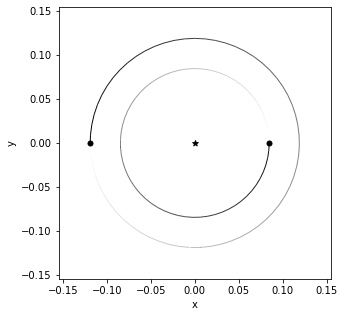

In [5]:
%matplotlib inline
op = rebound.OrbitPlot(sim)

### Saving a simulation
We can create a [simulation archive](https://rebound.readthedocs.io/en/latest/simulationarchive/) to store samples of the system as it evolves.  The `automateSimulationArchive` function allows us to specify a file name to store the samples, frequency for which to take samples (in time units given by sim.units), and whether to overwrite the previous file as a boolean.

```{note}
Replacing the `interval` argument with `step` is in general more reliable. The reason is that the number of timesteps is an integer value whereas the time is a floating point number. If you run long simulations, you might encounter issues with finite floating point precision. This only affects very high accuracy simulation where you want to make sure the outputs occur exactly at the right timestep.
```

```python
sim.automateSimulationArchive("archive.bin",interval=0.45,deletefile=True) #9/20 = 0.45 days (or 20 samples per orbit of inner planet)
sim.integrate(9*1000) #integrate the orbits for 1000 periods of the inner planet; this takes a few (~3-4) minutes
```

The simulation archive stores each sample similar to a python list, where each object in the list is itself a simulation.  Therefore, we can access the data file "archive.bin" iteratively by creating an instance of `SimulationArchive` (see [SimulationArchive examples](https://rebound.readthedocs.io/en/latest/ipython_examples/SimulationArchive/) for details).  We can then probe the simulation archive object `sa` using the dot convention for variables.  Upon inspection, we find that the time of the first and last snapshots are 0 and 9000 days, respectively.  The number of snapshots should be $1+20/9 \cdot 9000\ \rm days = 20,001\ \rm days$ including the initial snapshot at $t=0$.


In [11]:
sa = rebound.SimulationArchive("archive.bin")
print("Number of snapshots: %d" % len(sa))
print("Time of first and last snapshot: %.1f, %.1f" % (sa.tmin, sa.tmax))

Number of snapshots: 20001
Time of first and last snapshot: 0.0, 9000.0


### Plotting a simulation

To plot a simulation, we can use samples from the `SimulationArchive` and create a visualization through `matplotlib`.  The example below walks through the basic setup of creating a plot, where there are many ways to customize the appearance (see [matplotlib documentation](https://matplotlib.org/stable/index.html) for more details).

First, we need to access the functions within the `matplotlib` library and more specificially, those in the `pyplot` sublibrary.  In python, this is done through the `import` statement and we can denote a reference label `plt`,

```python
import matplotlib.pyplot as plt
```

so that we can more easily reference the functions without using the full path to the function.

The simulation above considers two planets, where we can designate data points for each planet by color: inner (black) and outer (red).  Also we know that there will be three particles (star, inner planet, outer planet) and the `ps` list holds objects representing each body at each snapshot in time.  Therefore, it would be convenient to iterate through the colors following the same counting scheme as we iterate through the particles (i.e., particle index $i = \{0,\ 1,\ 2\}$).  Let's define a color list as

```python
color = ['','k','r']
```

where this list skips the position zero (using an empty string `''`) for the host star, assigns `'k'` (black) in the first position, and `'r'` (red) in the final position.  A `for` loop that iterates through the particles will begin at $0$ and continue non-inclusively until it reaches $3$ (i.e., only evaluating $i = \{0,\ 1,\ 2\}$).

Then, a `figure` instance is created using the `plt` label.  Arguments of the `figure` can include the: 

- size of the figure; `figsize=(w,h)` with the width `w` and height `h` measured in *inches*,
- resolution of the figure in *dots per inch* `dpi`; the default is $75$, but it is often better to use $150$.

Following the `figure` is the creation of a reference axis `ax` by using the function `add_subplot`.  This function creates a *canvas* for which to add our points and requires information concerning the number of rows $r$, columns $c$, and the index $i$ of the subplot.  Together these instances are

```python
fig = plt.figure(figsize=(5,5),dpi=150)
ax = fig.add_subplot(111)
```

where `h=w=5`, `dpi=150`, and `rci=111`.

The simulation archive is sampled using a `for` loop that iterates through each snapshot, while a second `for` loop iterates through the particles.  Within the second `for` loop dots are plotted onto the axis `ax` with a marker `'.'` (dot) and markersize `ms=4`.  Note that we expect ~20 equally spaced positions for the inner planet (due to our output sampling) and a continuous curve for the outer planet.  In python, this code is:

```python
for s in range(0,len(sa)):
    sim = sa[s] #iterate through each snapshot in sa
    ps = sim.particles #intermediate object to simpify the referencing
    for i in range(1,len(ps)): #iterate through each of the particles, skipping the host star 
        ax.plot(ps[i].x,ps[i].y,'.',ms=4,color=color[i])
```

To make the resulting plot easier to read later, we can add labels to the $x$- and $y$-axis as strings and denote the point size of the font in `fontsize`.  The final line should contain a semicolon `;` at the end to prevent extra output.  The code for this customization is given by:

```python
ax.set_xlabel("x (AU)",fontsize=16)
ax.set_ylabel("y (AU)",fontsize=16);
```

Altogether, we can combine these statements into one code as:

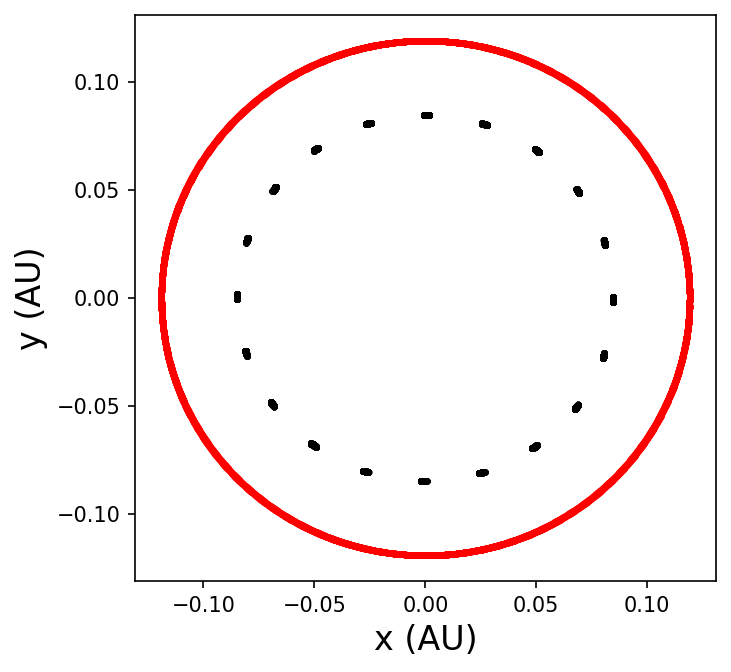

In [8]:
import matplotlib.pyplot as plt

color = ['','k','r']

fig = plt.figure(figsize=(5,5),dpi=150)
ax = fig.add_subplot(111)

for s in range(0,len(sa)):
    sim = sa[s] #iterate through each snapshot in sa
    ps = sim.particles #intermediate object to simpify the referencing
    for i in range(1,len(ps)): #iterate through each of the particles, skipping the host star 
        ax.plot(ps[i].x,ps[i].y,'.',ms=4,color=color[i])
ax.set_xlabel("x (AU)",fontsize=16)
ax.set_ylabel("y (AU)",fontsize=16);

## Simulating $\alpha$ Cen AB

To simulate the orbit of $\alpha$ Cen AB, we need to use the known orbital parameters.  The stellar masses and orbital elements are given in [Introduction to the $\alpha$ Centauri System](https://saturnaxis.github.io/exoplanet-binary/Tutorials/intro-alpha-centauri.html), but we'll use the binary orbital plane as a reference so that $i = \Omega = 0^\circ$ and $\omega = 77.05^\circ = (232.3^\circ + 204.75^\circ) \mod 360^\circ$.  Additionally, we need to specifiy a starting position using true anomaly $f$ or mean anomaly *MA*.  [Quarles & Lissauer (2016)](https://iopscience.iop.org/article/10.3847/0004-6256/151/5/111/pdf) calculated the binary mean anomaly for Julian date (JD) 2452276, which is $209.6901^\circ$ and we'll use it here.

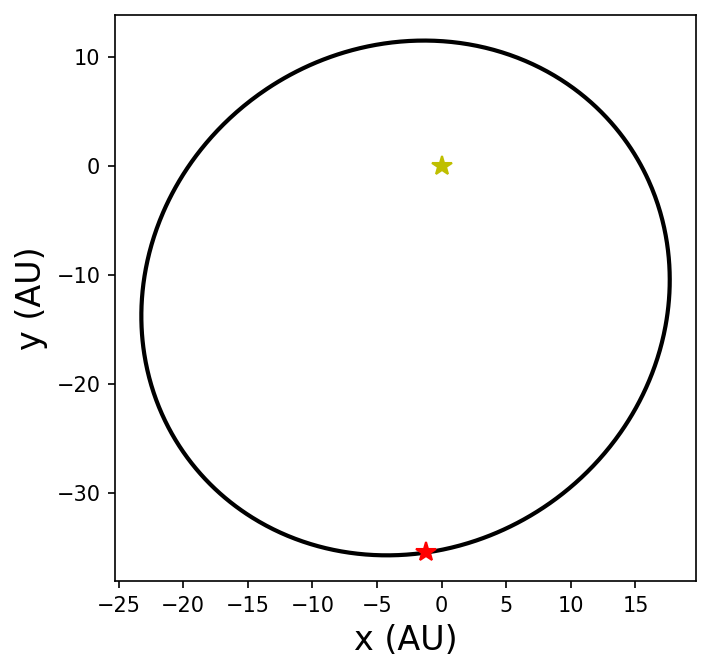

In [22]:
import rebound 
import numpy as np
import matplotlib.pyplot as plt

M_A = 1.133 #mass of star A in solar masses
M_B = 0.972 #mass of star B in solar masses
a_bin = 23.78 #semimajor axis in AU
e_bin = 0.524 #eccentricity
omg_bin = np.radians(77.05) #pericenter of binary converted to radians
MA_bin = np.radians(209.6901) #mean anomaly of binary @ JD 2452276
T_bin = np.sqrt(a_bin**3/(M_A+M_B)) #period of the binary in years

sim = rebound.Simulation()
sim.integrator = 'whfast'
sim.units = ('yr','Msun','AU')
sim.dt = 0.01 

sim.add(m=M_A)
sim.add(m=M_B,a=a_bin,e=e_bin,omega=omg_bin,M=MA_bin) #i=Omega=0 by default
sim.move_to_com()  #convert to center of mass coordinates

sim.automateSimulationArchive("alphaCen.bin",interval=0.1,deletefile=True)
sim.integrate(T_bin)

#plot the simulation
sa = rebound.SimulationArchive("alphaCen.bin")

fig = plt.figure(figsize=(5,5),dpi=150)
ax = fig.add_subplot(111)

ax.plot(0,0,'y*',ms=10)
xy_bin = np.zeros((len(sa),2))
for s in range(0,len(sa)):
    sim = sa[s] #iterate through each snapshot in sa
    ps = sim.particles #intermediate object to simpify the referencing
    sim.move_to_hel() #shift to astrocentric coordinates
    xy_bin[s,:] = [ps[1].x,ps[1].y]
ax.plot(xy_bin[:,0],xy_bin[:,1],'k-',lw=2)
ax.plot(xy_bin[0,0],xy_bin[0,1],'r*',ms=10)
ax.set_xlabel("x (AU)",fontsize=16)
ax.set_ylabel("y (AU)",fontsize=16);

## Adding a planet

### Jacobi coordinates

### Barycentric coordinates